# LSTM model for sentiment Analysis

In [41]:
import joblib
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

## Read the embeddings and Labels

In [2]:
X_train = joblib.load('train_embeddings.pkl')
y_train = pd.read_csv('training.csv')['label'].values

X_val = joblib.load('validation_embeddings.pkl')
y_val = pd.read_csv('validation.csv')['label'].values

X_test = joblib.load('test_embeddings.pkl')
y_test = pd.read_csv('test.csv')['label'].values

## Number of classes or emotions

In [3]:
print("Unique labels in training set:", np.unique(y_train))
print("Min label:", np.min(y_train))
print("Max label:", np.max(y_train))

Unique labels in training set: [0 1 2 3 4 5]
Min label: 0
Max label: 5


In [4]:
X_train.shape, y_train.shape

((16000, 768), (16000,))

In [5]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

## Convert the data into Dataset and DataLoader



In [6]:
class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # Lista de embeddings generados por RoBERTa
        self.labels = labels.squeeze()  # Lista de etiquetas

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
# Dataset type conversion
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

# DataLoaderr to make use of batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
type(train_dataset), type(train_loader)

(__main__.EmotionDataset, torch.utils.data.dataloader.DataLoader)

## LSTM Model

Parameters:
- Input_size: Embeddings size
- Hidden_size: Number of neurons in the LSTM
- num_layers: Number of stacking LSTM
- output_size: number of emotions or classes

In [42]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
    # Input Size = Embedding Dimension
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Create the LSTM NN
    self.lstm = nn.LSTM(
        input_size,
        hidden_size,
        num_layers,
        dropout=dropout,
        batch_first=True
      )

    # Layer Normalization
    self.layer_norm = nn.LayerNorm(hidden_size)

    # Fully Connected Layer to make predictions
    self.classifier = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim // 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim // 2, output_dim)
    )


  def forward(self, x):
    if len(x.shape) == 2:
            x = x.unsqueeze(1)  # Agrega dimensión de secuencia (batch_size, 1, embedding_dim)

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    # LSTM output: output of all the hidden_state, hidde_state, cell_state
    lstm_out, (hidden, _) = self.lstm(x, (h0,c0))
    # out: batch_size, seq_length, hidden_state

    # Layer normalization
    normalized = self.layer_norm(lstm_out[:, -1, :])

    # Classification layers
    output = self.classifier(normalized)
    return output

### Entrenar y Evaluar

In [53]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5, device="cpu"):
    best_val_f1 = 0
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_predictions = []
        train_true_labels = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Forward
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions for F1-score
            predictions = torch.argmax(outputs, dim=1)
            train_predictions.extend(predictions.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Calculate Training F1-score
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')
        train_f1_scores.append(train_f1)

        # Validation phase
        model.eval()
        val_predictions = []
        val_true_labels = []
        val_loss = 0

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Store predictions for F1-score
                predictions = torch.argmax(outputs, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate Validation F1-score
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
        val_f1_scores.append(val_f1)

        # Print epoch results
        if epoch %10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Training Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print(f"Training F1-Score: {train_f1:.4f} | Validation F1-Score: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    return train_losses, val_losses, train_f1_scores, val_f1_scores


In [46]:
def plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores):
    plt.figure(figsize=(14, 6))

    # Losses (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # F1-scores (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1-Score')
    plt.plot(val_f1_scores, label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Hiperparámetros

In [54]:
embedding_dim = 768  # Embedding size
hidden_dim = 128
output_dim = 6  # Number of emotion or classes
num_layers = 2
dropout = 0.3

# Model
model = LSTM(embedding_dim, hidden_dim, num_layers, output_dim, dropout)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, train_f1_scores, val_f1_scores = train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=5
)

Epoch 1/200
Training Loss: 1.2187 | Validation Loss: 1.0604
Training F1-Score: 0.5085 | Validation F1-Score: 0.5632
Epoch 11/200
Training Loss: 0.7893 | Validation Loss: 0.7977
Training F1-Score: 0.7027 | Validation F1-Score: 0.6953
Epoch 21/200
Training Loss: 0.6898 | Validation Loss: 0.7724
Training F1-Score: 0.7365 | Validation F1-Score: 0.7156
Early stopping triggered


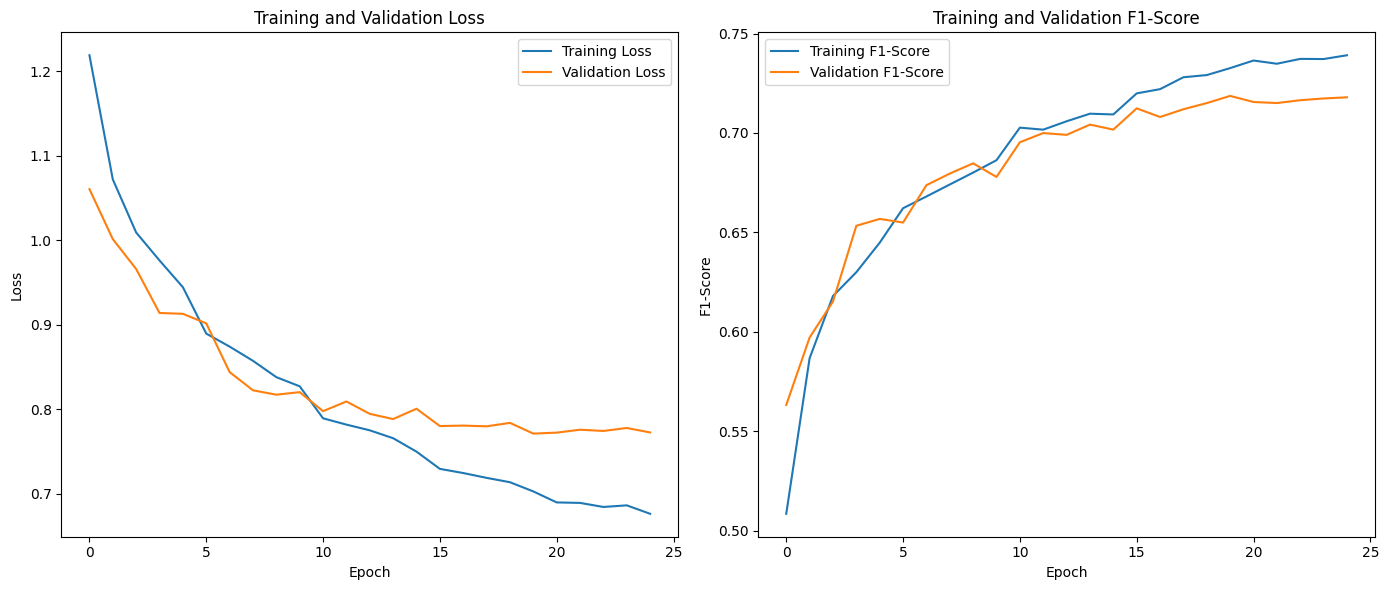

In [55]:
plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores)